 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 5. Machine Learning Basis**
# Section 2. Linear Regression & Loss Function

### _Objective_
1. 머신러닝의 알고리즘 중 가장 기본이 되는 선형 회귀에 대해 알아봅니다.<br>
2. 선형 회귀를 최적화하기 위한 식인 Loss Function에 대해 알아봅니다.<br>
  
╚═════════════════════════════════════════╝

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt

## 예제 데이터 ) 빅데이터로 예측한 '옥자' 관객 수

"이전까지 개봉했던 영화의 보고싶어요 수와 관객 수를 바탕으로, 옥자의 예상 관객 수 예측하기"

reference : [빅데이터로 예측한 옥자 관객 수 727만 명](http://platum.kr/wp-content/uploads/2017/06/unnamed-12.png)
![](http://platum.kr/wp-content/uploads/2017/06/unnamed-12.png)

| 영화 제목 | 왓챠'보고싶어요' 수 | 총 관객 수(만명) | 
| ------  | -------        | -----    |
| 마션     | 8759           | 487      |
| 킹스맨   | 10132           | 612     |
| 캡틴아메리카 | 12078         | 866     |
| 인터스텔라 | 16430          | 1030    |
| 옥자     | 12008          | ?       |

In [2]:
movie_df = pd.DataFrame([
    [8759, 487],
    [10132,612],
    [12078,866],
    [16430,1030]],
    columns=["nums_want_to_see","nums_audience"])
movie_df.index = ["마션","킹스맨","캡틴아메리카","인터스텔라"]
movie_df

,nums_want_to_see,nums_audience
마션,8759,487
킹스맨,10132,612
캡틴아메리카,12078,866
인터스텔라,16430,1030


<br><br>

# \[ 1. 선형회귀 \]

----

----

> *선형 회귀는 특징 정보 간의 관계를 **선형**적이라고 가정한 머신러닝 모델입니다.  *<br>
> *선형 회귀는 다수의 독립 변수(X)을 바탕으로 종속 변수(Y)와의 상관 관계를 모델링합니다. *

<br>

## 1. 데이터 확인하기

---

+ 우리는 데이터를 시각화하여, 우선 독립 변수인 "보고싶어요" 수와 종속 변수인 "총 관객 수"의 관계를 볼 수 있다.


### (1) 데이터 산포도 그리기

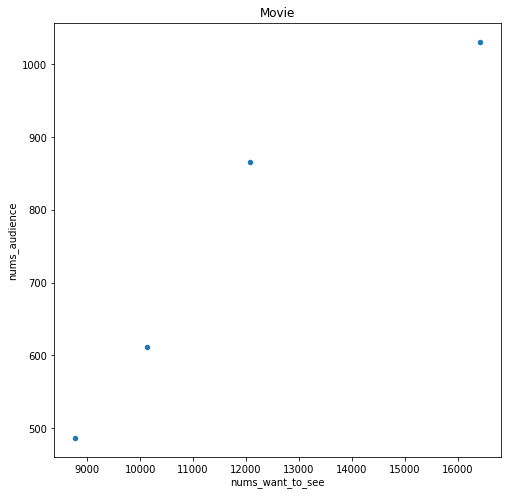

In [3]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

movie_df.plot(x='nums_want_to_see',y='nums_audience',
              kind='scatter', ax=ax, title="Movie")
plt.show()

우리는 위의 산포도를 통해, 대략적으로 보고싶어요 수 와 총관객수가 선형적인 관계임을 볼 수 있습니다.

### (2) 대략적인 추세선 그려보기

선형 함수의 추세 함수는 아래의 식입니다.<br>
우리는 "보고싶어요" 수($X$)를 통해 얼마나 많은 고객들이 볼지($\hat y$)를 예측합니다.

$$
\hat y = w_1 x + w_0
$$

우리는 아래와 같이 추세선을 예상할 수 있습니다.

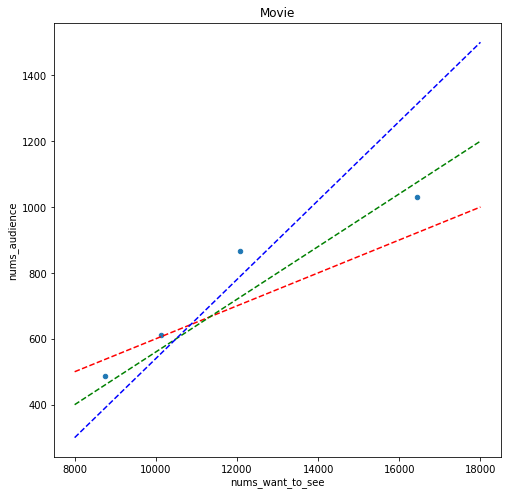

In [4]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

movie_df.plot(x='nums_want_to_see',y='nums_audience',
              kind='scatter', ax=ax, title="Movie")

plt.plot([8000,18000],[500,1000],'r--')
plt.plot([8000,18000],[400,1200],'g--')
plt.plot([8000,18000],[300,1500],'b--')

plt.show()

위의 추세선 별로 예측 함수는 아래와 같습니다.


* 붉은 색 예측 함수 : $\hat y_{red} = 0.05x+100$
* 초록 색 예측 함수 : $\hat y_{green} = 0.08x-240$
* 파란 색 예측 함수 : $\hat y_{blue} = 0.12x-600$

옥자의 현재 보고싶어요 수는 12,008인데, 각 예측 함수별로 유추한 예상 총 관객수 는

In [5]:
nums_by_red = 0.05 * 12008 + 100
print("붉은 색 예측 함수로 보았을 때 총 관객 수 : {}만명".format(nums_by_red))
nums_by_green = 0.08 * 12008 - 240
print("초록 색 예측 함수로 보았을 때 총 관객 수 : {}만명".format(nums_by_green))
nums_by_red = 0.12 * 12008 - 600
print("파란 색 예측 함수로 보았을 때 총 관객 수 : {}만명".format(nums_by_red))

붉은 색 예측 함수로 보았을 때 총 관객 수 : 700.4만명
초록 색 예측 함수로 보았을 때 총 관객 수 : 720.64만명
파란 색 예측 함수로 보았을 때 총 관객 수 : 840.96만명


이 중에서 어떤 예측이 더 정확한지를 말하기 위해서는<br>
어떤 추세선이 더 올바른 추세선인지를 파악할 수 있는 기준이 필요합니다.<br>
이러한 기준을 제시하는 것이 바로 손실 함수, 즉 `Loss Function`입니다.

<br><br>

# \[ 2. 손실 함수 \]

----

----

> *손실함수는 모델의 가중치를 결정하는 함수로, 실제 값과 가설함수의 차이를 뜻합니다. *<br>

<br>

## 1. 손실함수 정의

---

+ 우리는 각 추세선(red,green,blue)이 실제 값과 얼마나 오차가 나오는지를 손실 함수를 통해 계산해보도록 하겠습니다

| 추세선(색) | $W_1$ |  $W_0$ |
| ----- | ---- | ---- |
| Red   | 0.05 | 100  |
| Green  | 0.08 | -240 |
| Blue | 0.12 | -600 |

In [6]:
# 예측 함수 설정하기
predict_by_red = lambda x : 0.05*x + 100
predict_by_green = lambda x : 0.08*x - 240
predict_by_blue = lambda x : 0.12*x - 600

In [7]:
# 예측 함수 적용하기
movie_df['red 예측 결과'] = movie_df.nums_want_to_see.apply(predict_by_red)
movie_df['green 예측 결과'] = movie_df.nums_want_to_see.apply(predict_by_green)
movie_df['blue 예측 결과'] = movie_df.nums_want_to_see.apply(predict_by_blue)
movie_df

,nums_want_to_see,nums_audience,red 예측 결과,green 예측 결과,blue 예측 결과
마션,8759,487,537.95,460.72,451.08
킹스맨,10132,612,606.60,570.56,615.84
캡틴아메리카,12078,866,703.90,726.24,849.36
인터스텔라,16430,1030,921.50,1074.40,1371.60


예측한 값과 실제 값이 작을수록 우리는 좋은 예측이라고 말할 수 있습니다.<br>
이를 위해 우리는 예측값과 실제 값의 차이를 예측 함수 별로 구해보도록 하겠습니다.

In [8]:
movie_df['red error'] = movie_df.nums_audience - movie_df['red 예측 결과']
movie_df['green error'] = movie_df.nums_audience - movie_df['green 예측 결과']
movie_df['blue error'] = movie_df.nums_audience - movie_df['blue 예측 결과']
movie_df

,nums_want_to_see,nums_audience,red 예측 결과,green 예측 결과,blue 예측 결과,red error,green error,blue error
마션,8759,487,537.95,460.72,451.08,-50.95,26.28,35.92
킹스맨,10132,612,606.60,570.56,615.84,5.40,41.44,-3.84
캡틴아메리카,12078,866,703.90,726.24,849.36,162.10,139.76,16.64
인터스텔라,16430,1030,921.50,1074.40,1371.60,108.50,-44.40,-341.60


위와 같이 각 예측함수의 예측값과 실제값의 차이를 오차(error)라고 부릅니다.<br>
우리는 모델의 성능을 평가하기 위해, 오차를 이용해 기준을 세워야 합니다.

### (1) 오차의 평균 적용

$$
\mbox{오차의 평균} = \frac{1}{4}\sum_{movie={\mbox{4개 영화}}} (\hat y^{movie} - y^{movie})
$$

In [9]:
# 오차의 평균을 적용
movie_df[['red error','green error','blue error']].mean()

red error      56.2625
green error    40.7700
blue error    -73.2200
dtype: float64

단순히 오차의 평균을 적용하면 아래처럼, 파란 색 선이 가장 오차가 작다고 나타나게 됩니다. <br>
이는 오차의 부등호가 +,-가 동시에 존재해, 상쇄되기 때문입니다.

### (2) 오차 제곱평균 적용

$$
\mbox{오차의 제곱평균} = \frac{1}{4}\sum_{movie={\mbox{4개 영화}}} (\hat y^{movie} - y^{movie})^{2}
$$

In [10]:
# 오차의 제곱 평균을 적용
(movie_df[['red error','green error','blue error']] ** 2).mean()

red error      10168.430625
green error     5978.032400
blue error     29568.110400
dtype: float64

이 경우 우리는 초록 색선이 가장 오차가 작다고 나타나게 됩니다. <br>
직관적으로 바라보았을 때에도 초록색선이 가장 오차가 적게 보입니다. <br>
MSE(Mean-Squared-Error)라 불리는 위의 수식은 이후에도 자주 쓰이는 손실 함수 중 하나입니다.

<br>

## 2. Grid Search로 최적의 가중치 찾기

---

+ 손실함수를 가장 적게 하는 최적의 weight는 무엇일까요? 이를 구하는 가장 간단한 방법은 모든 조합의 weight들을 넣어보는 것입니다.

### (0) 수식으로 해석하기

우리가 목표로 하는 것은 
$$
Loss =\frac{1}{2m}\sum^{m}_{i=1}(\hat y^{(i)}-y^{(i)})^2
$$
를 최소화하는 Weight를 찾는 것입니다.<br>

### (1) 가중치 조합 만들기

우리는 가능한 가중치의 조합을 만들어보고자 합니다.

In [11]:
W0s = np.linspace(-1000,1000,100)
W1s = np.linspace(-1,1,100)

points = np.stack(np.meshgrid(W0s,W1s),axis=-1) # 가중치 조합 만들기
points = points.reshape(-1,2)
points

array([[-1000.       ,    -1.       ],
       [ -979.7979798,    -1.       ],
       [ -959.5959596,    -1.       ],
       ...,
       [  959.5959596,     1.       ],
       [  979.7979798,     1.       ],
       [ 1000.       ,     1.       ]])

### (2) 손실함수값 계산하기

$$
Loss =\frac{1}{2m}\sum^{m}_{i=1}(\hat y^{(i)}-y^{(i)})^2
$$

In [22]:
def calculate_MSE(W0, W1):
    X = movie_df.nums_want_to_see # 독립 변수, 보고싶어요 수
    y_true = movie_df.nums_audience # 실제값

    y_pred = W1*X+W0 # 가중치 조합을 통한 예측값
    return ((y_true - y_pred)**2).mean() # MSE

In [23]:
losses = []
for W0, W1 in points:
    loss = calculate_MSE(W0, W1)
    losses.append(loss)
losses = np.array(losses)

### (3) 가중치 별 손실값 확인하기

In [24]:
points_with_loss = np.concatenate([points,
                                   losses.reshape(-1,1)],
                                  axis=1)

loss_df = pd.DataFrame(points_with_loss,columns=['W0','W1','Loss'])
loss_df.sample(10)

,W0,W1,Loss
10,-797.979798,-1.000000,1.890737e+08
7518,-636.363636,0.515152,2.393409e+07
31,-373.737374,-1.000000,1.778869e+08
2231,-373.737374,-0.555556,6.266530e+07
7741,-171.717172,0.555556,3.404377e+07
7377,555.555556,0.474747,3.088606e+07
4856,131.313131,-0.030303,1.042046e+06
1509,-818.181818,-0.696970,1.014868e+08
5294,898.989899,0.050505,5.674027e+05
1133,-333.333333,-0.777778,1.120941e+08


### (4) 최적의 조합 찾기

In [25]:
loss_df.sort_values('Loss').iloc[0] # Loss가 가장적은 weight

W0       -90.909091
W1         0.070707
Loss    3538.206305
Name: 5345, dtype: float64

이것으로 우리는 Loss가 가장 적은 가중치 조합이 $(W_0,W_1)=(-90.9,0.07)$임을 알 수 있다.

### (5) 가중치 시각화

모든 가중치에 대한 Loss 값을 시각화해 보겠습니다.

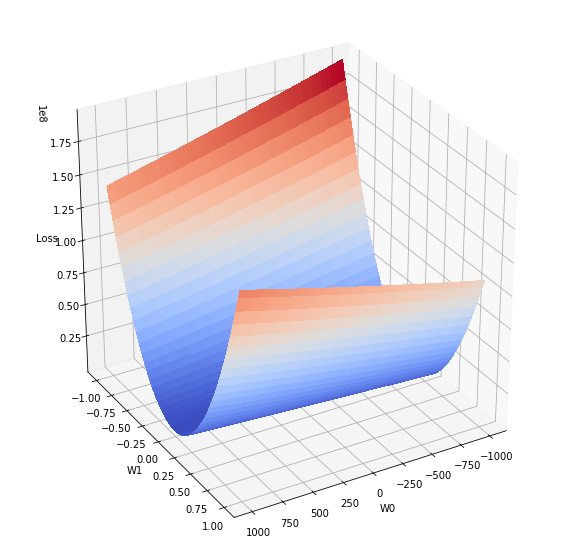

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

surf_value = loss_df.values.reshape(100,100,3)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X=surf_value[:,:,0],
                       Y=surf_value[:,:,1],
                       Z=surf_value[:,:,2],
                       cmap=cm.coolwarm,
                       linewidth=0,
                       antialiased=False)
ax.view_init(azim=60)
ax.set_xlabel('W0')
ax.set_ylabel('W1')
ax.set_zlabel('Loss')
plt.show()

우리는 위의 함수를 통해, 손실함수가 볼록한 형태(Convex)임을 알 수 있다.<br>
위와 같이 Grid Search을 할 경우, 수만번의 연산이 필요하다.<br>
우리는 보다 적은 횟수로 손실함수의 최솟값을 찾아낼 수 있는<br>
Gradient Descent 방법을 다음 시간에 배워보도록 한다.

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/22

---